# Street View House Numbers (SVHN)

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: September 9, 2018
* Description: Preprocessing original street view house number whole images with images containing anywhere from a single digit to multiple digits
* Dataset: [SVHN dataset](http://ufldl.stanford.edu/housenumbers/)

---------

### Dataset Description

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST(e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

### Dataset Overview

- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- In terms of individual digits, there are: 
    - 73,257 digits for training 
    - 26,032 digits for testing 
    - 531,131 digits to use as extra training data
- In terms of images, there are a total of:
    - 33,401 images for training
    - 13,068 images for testing
    - 202,353 extra images
- Data Format: 
    - **Original images (ranging from 1 digit to 6 digits an image) with character level bounding boxes.**


# Preprocessing Phases

1. Parse through the provided mat files with bounding box information for images
    - Convert this format to a data frame for easier processing
2. Crop images using the bounding boxes of each individual character, and expand the box by 30-40% and resize to 32x32.
3. Data exploration & visualization
    - Get a better idea of the data (such as bounding boxes of images, how many digits are in each image, etc.)
    - Plot distributions of number of digits in each image
4. Data removal
5. Convert to grayscale
6. Save preprocessed data to disk

In [1]:
# OS packages
import os
import sys

# linear algebra
import numpy as np

# data processing 
import pandas as pd

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML

# File format/ file system packages
import json
import h5py
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Bounding Boxes

- Use a class to create array of dictionaries containing filename & boudning boxes for every digit in image.
    - `DigitStructWrapper` is adapted from https://github.com/hangyao
- The downloaded `digitStruct.m` contains labels and information on the bounding boxes. 

In [ ]:
class DigitStructWrapper:
    """
    Wrapper for the H5PY digitStruct files from the SVHN dataset
    Creates an array of dictionaries containing the filename and bounding boxes for every digit in the image.
    Adapted from https://github.com/hangyao
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        """Return the name of the n(th) digit struct"""
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def get_attribute(self, attr):
        """Helper function for dealing with one vs. multiple bounding boxes"""
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def get_bbox(self, n):
        """Return a dict containing the data from the n(th) bbox"""
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        """Return the name and bounding boxes of a single image"""
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        """Returns a list of dicts containing all the bounding boxes"""
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result


In [ ]:
def parse_info(start_path = '.'):
    """ Extracts a bounding box file and returns a dictionary
    """
    return DigitStructWrapper(start_path).unpack_all()

# Extract info from mat files such as the bounding boxes
train_bbox = parse_info('data/train/digitStruct.mat')
test_bbox = parse_info('data/test/digitStruct.mat')
extra_bbox = parse_info('data/extra/digitStruct.mat')

# Display the information stored about an individual image
print(json.dumps(train_bbox[0], indent=2))

### Visualize bounding boxes on dataset

In [2]:
from PIL import Image, ImageDraw

def display_boxes(img, bounding_boxes):
    """Displays an image and overlays the bounding boxes
    """
    # Opens and identifies the given image file
    image = Image.open(img)
    
    # Use draw module can be used to annotate the image
    draw = ImageDraw.Draw(image)
    
    for b in bounding_boxes:
        
        # Bounding box rectangle [x0, y0, x1, y1]
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        
        # Draw a rectangle on top of the image
        draw.rectangle(rectangle, outline="blue")
        
    # Return altered image    
    return image


# Select an image and the corresponding boxes
image = 'data/train/30485.png'
image_bounding_boxes = train_bbox[30484]['boxes']
     
# Display image with bounding boxes
display_boxes(image, image_bounding_boxes)

NameError: name 'train_bbox' is not defined

### Convert Python dictionary data to pandas dataframe

- Will be easier to work with when we do operations on the data (`pandas` is built on `numpy` thus optimized for vectorized & fast operations)

In [3]:
def dict_to_df(image_bounding_boxes, path):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# Save bounding box data to csv
bbox_file = 'data/bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_df(train_bbox, 'data/train/')
    test_df = dict_to_df(test_bbox, 'data/test/')
    extra_df = dict_to_df(extra_bbox, 'data/extra/')

    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print("Extra", extra_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df, extra_df])
    
    print("Combined", df.shape)

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes to save memory
    del train_df, test_df, extra_df, train_bbox, test_bbox, extra_bbox
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)

# Display the first 10 rows of dataframe
df.head()

,filename,height,label,left,top,width
0,data/train/1.png,219.0,1.0,246.0,77.0,81.0
1,data/train/1.png,219.0,9.0,323.0,81.0,96.0
2,data/train/2.png,32.0,2.0,77.0,29.0,23.0
3,data/train/2.png,32.0,3.0,98.0,25.0,26.0
4,data/train/3.png,15.0,2.0,17.0,5.0,8.0


### Group images by filename

- Images with multiple digits will have multiple rows in the dataframe
- Group & aggregate these images together, then take the mininum of the coordinates (left, top) or (x0, y0) and maximum (right, bottom) or (x1, y1) of each combined image

In [4]:
# Rename the columns to more suitable names
df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)

# Calculate x1 and y1
df['x1'] = df['x0'] + df['width']
df['y1'] = df['y0'] + df['height']

# Perform the following aggregations on the columns
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             'label':{
                'labels': lambda x: list(x),
                'num_digits': 'count'}}

# Apply the aggegration
df = df.groupby('filename').agg(aggregate).reset_index()

# Fix the column names after aggregation
df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

# Display the results
df.head()

/usr/local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,filename,x0,y0,x1,y1,labels,num_digits
0,data/extra/1.png,24.0,23.0,126.0,126.0,"[4.0, 7.0, 8.0]",3
1,data/extra/10.png,5.0,5.0,52.0,32.0,"[4.0, 4.0, 4.0]",3
2,data/extra/100.png,3.0,1.0,46.0,30.0,"[5.0, 3.0, 5.0]",3
3,data/extra/1000.png,9.0,7.0,36.0,40.0,"[2.0, 6.0]",2
4,data/extra/10000.png,8.0,9.0,41.0,35.0,"[2.0, 10.0, 10.0]",3


### Expand boxes in images


- Expand the width & height (x & y) of each image by 35% 
- We will visualize these by plotting a before and after the expansion

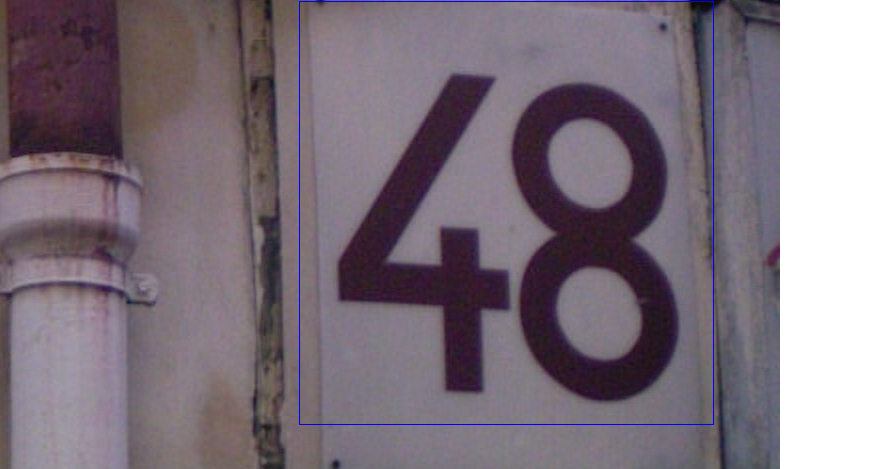

In [5]:
from PIL import Image, ImageDraw

# Before expansion
def display_bbox(image_path, bbox):
    """ Helper function to display a single image and bounding box
    """
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image


# Select a image and bounding box
image = 'data/train/30485.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

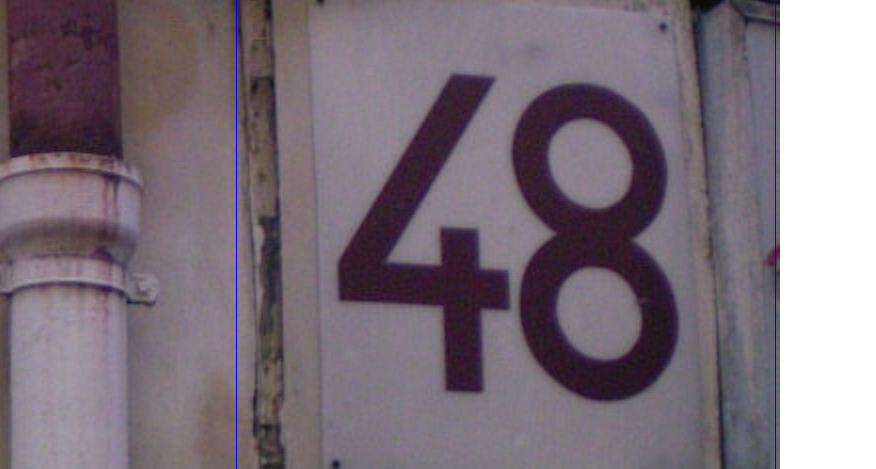

In [6]:
# After expansion

# Calculate the increase in both directions
df['x_inc'] = ((df['x1'] - df['x0']) * 0.30) / 2.
df['y_inc'] = ((df['y1'] - df['y0']) * 0.30) / 2.

# Apply the increase in all four directions
df['x0'] = (df['x0'] - df['x_inc']).astype('int')
df['y0'] = (df['y0'] - df['y_inc']).astype('int')
df['x1'] = (df['x1'] + df['x_inc']).astype('int')
df['y1'] = (df['y1'] + df['y_inc']).astype('int')


# Select the dataframe row corresponding to our image
image = 'data/train/30485.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

## Image Sizes

- `The digitStruct` files did not contain any information on the file sizes of the images. 
- Since this information could be relevant for our preprocessing, e.g. in case we want to remove low-quality images or improve our cropping procedure.
- We want to get all the sizes & then merge them into our main dataframe


In [7]:
def get_img_size(filepath):
    """Returns the image size in pixels given as a 2-tuple (width, height)
    """
    image = Image.open(filepath)
    return image.size 

def get_img_sizes(folder):
    """Returns a DataFrame with the file name and size of all images contained in a folder
    """
    image_sizes = []
    
    # Get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    
    # Get image size of every individual image
    for image in images:
        w, h = get_img_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes)


# Extract the image sizes
train_sizes = get_img_sizes('data/train/')
test_sizes = get_img_sizes('data/test/')
extra_sizes = get_img_sizes('data/extra/')

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])

# Delete old dataframes
del train_sizes, test_sizes, extra_sizes

# Display 10 image sizes
image_sizes.head(10)

,filename,image_height,image_width
0,data/train/20037.png,41,92
1,data/train/3975.png,31,59
2,data/train/30224.png,34,82
3,data/train/27758.png,81,182
4,data/train/29775.png,59,125
5,data/train/17843.png,76,158
6,data/train/26446.png,49,93
7,data/train/16585.png,49,95
8,data/train/21329.png,54,120
9,data/train/27980.png,54,137


In [8]:
# Let's merge the dataframes

print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# Inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)

# Delete the image size df
del image_sizes

# Store checkpoint
df.to_csv("data/image_data.csv", index=False)
#df = pd.read_csv('data/image_data.csv')

df.head()

Bounding boxes (248823, 9)
Image sizes (248823, 3)

Combined (248823, 11)


,filename,x0,y0,x1,y1,labels,num_digits,x_inc,y_inc,image_height,image_width
0,data/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,141,166
1,data/extra/10.png,-2,0,59,36,"[4.0, 4.0, 4.0]",3,7.05,4.05,41,52
2,data/extra/100.png,-3,-3,52,34,"[5.0, 3.0, 5.0]",3,6.45,4.35,32,51
3,data/extra/1000.png,4,2,40,44,"[2.0, 6.0]",2,4.05,4.95,49,51
4,data/extra/10000.png,3,5,45,38,"[2.0, 10.0, 10.0]",3,4.95,3.90,44,55


### Image Correction

- As noticed above, some of the boxes are not correctly bounded & will surpass the image size, so let's fix it 

In [9]:
# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_height']

df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_inc,y_inc,image_height,image_width
0,data/extra/1.png,8,7,141,141,"[4.0, 7.0, 8.0]",3,15.30,15.45,141,166
1,data/extra/10.png,0,0,52,36,"[4.0, 4.0, 4.0]",3,7.05,4.05,41,52
2,data/extra/100.png,0,0,51,32,"[5.0, 3.0, 5.0]",3,6.45,4.35,32,51
3,data/extra/1000.png,4,2,40,44,"[2.0, 6.0]",2,4.05,4.95,49,51
4,data/extra/10000.png,3,5,45,38,"[2.0, 10.0, 10.0]",3,4.95,3.90,44,55


                    filename   x0  y0   x1   y1      labels  num_digits  \
238184  data/train/30485.png  236   0  775  469  [4.0, 8.0]           2   

        x_inc  y_inc  image_height  image_width  
238184   62.1  63.45           469          876  


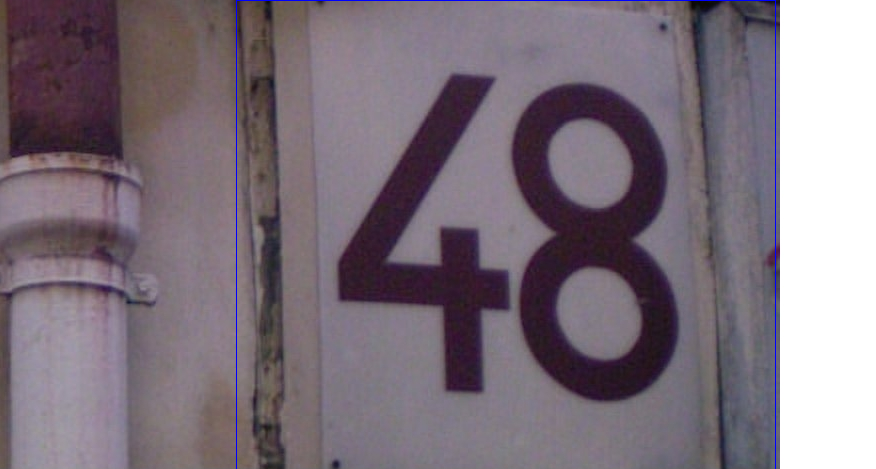

In [10]:
# Check by replotting the image from above

# Select the dataframe row corresponding to our image
image = 'data/train/30485.png'
bbox = df[df.filename == image]

print(bbox)
# Display image
display_bbox(image, bbox)

## Data Verification

- Let's first remove the image with 5 digits (since there is only one & will seriously imbalance our algorithm)
- Then, we will scale all these images to a standard 32x32, and do a verification of the images

In [11]:
# Count the number of images by number of digits
df.num_digits.value_counts(sort=False)

1     17005
2     98212
3    117561
4     15918
5       126
6         1
Name: num_digits, dtype: int64

In [12]:
# Keep only images with less than 6 digits
df = df[df.num_digits < 6]

### Data Quality Verification

- Images have variable sizes.
    - Some images in the dataset are super small. We should verify that some of these images looks OK after cropping and scaling them to 32 x 32 pixels.

In [13]:
df[['image_width', 'image_height']].describe()

,image_width,image_height
count,248822.000000,248822.000000
mean,107.925662,60.884194
std,63.223155,32.392831
min,22.000000,12.000000
25%,69.000000,40.000000
50%,92.000000,53.000000
75%,127.000000,74.000000
max,1083.000000,516.000000


## Crop & resize images

- Crop images by bounding boxes
- Resize to a standard image size (easily divisible by 2)
    - I choose 32 x 32 sized images

In [14]:
from scipy.ndimage import imread
from scipy.misc import imresize

def crop_and_resize(image, img_size):
    """ Crop and resize an image
    """
    image_data = imread(image['filename'])
    crop = image_data[image['y0']:image['y1'], image['x0']:image['x1'], :]
    return imresize(crop, img_size)


def create_dataset(df, img_size):
    """ Helper function for converting images into a numpy array
    """
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype='uint8')
    y = np.full((df.shape[0], 5), 10, dtype=int)
    
    # Iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        
        # Get the image data
        X[i] = crop_and_resize(image, img_size)
        
        # Get the label list as an array
        labels = np.array((image['labels']))
                
        # Store 0's as 0 (not 10)
        labels[labels==10] = 0
        
        # Embed labels into label array
        y[i,0:labels.shape[0]] = labels
        
    # Return data and labels   
    return X, y


# Change this to select a different image size
image_size = (32, 32)

# Get cropped images and labels (this might take a while...)
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)
X_extra, y_extra = create_dataset(df[df.filename.str.contains('extra')], image_size)

# We no longer need the dataframe
del df

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
print('Extra', X_extra.shape, y_extra.shape)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Training (33401, 32, 32, 3) (33401, 5)
Test (13068, 32, 32, 3) (13068, 5)
Extra (202353, 32, 32, 3) (202353, 5)


## Image Quality Verification

- Let's do a sanity check to verify that the images look good when we cropped and rescaled, and that they somewhat match the label
- We will run this on all sets (train, test, extra)

In [16]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Helper function for plotting nrows * ncols images
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "Label: {0}".format(true_number)
        else:
            # Pretty string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "Label: {0}, Pred: {1}".format(true_number, pred_number)  
            
        if images[i].shape == (32, 32, 3):
            ax.imshow(images[i])
        else:
            ax.imshow(images[i,:,:,0], cmap="gray")
#         ax.imshow(images[i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

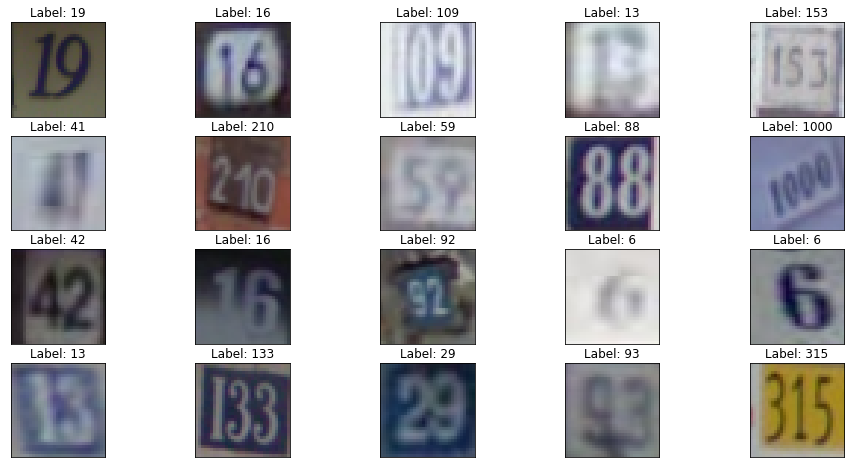

In [17]:
# Display images from the training set
plot_images(X_train, 4, 5, y_train)

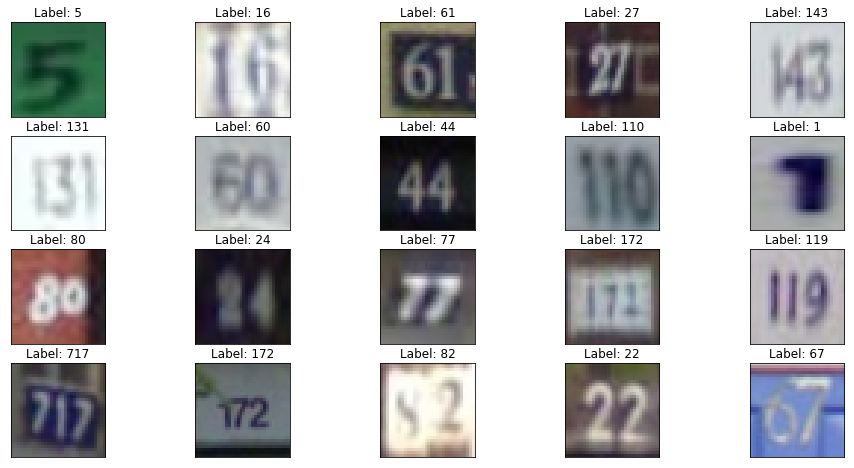

In [18]:
# Display images from the training set
plot_images(X_test, 4, 5, y_test)

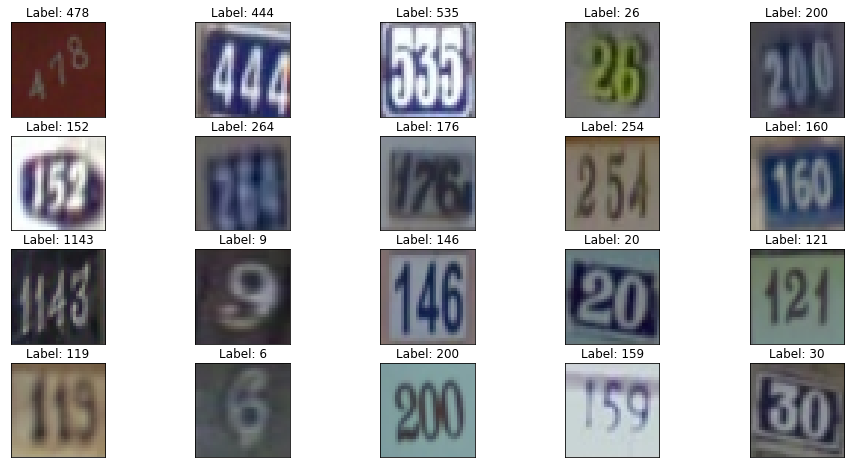

In [19]:
# Display images from the training set
plot_images(X_extra, 4, 5, y_extra)

### Scale & Rotation Invariance Observation

- Check the edge cases, 1 and 5 digits images, to check how much scale invariance we have introduced to our dataset through our cropping and rescaling procedure. 
- The crops for images with 1 digit have a fairly high height and small width causing the images to be stretched out horizontally when it is resized. The opposite might apply to images with 5 digits where our images could be stretched out vertically.
- We need to design a neural network that is scale-invariant
    - Convolutional networks are translation invariant, but not directly scale-invariant or rotation invariant
        - However, we can alter the traditional CNN architecture to handle scale & rotation invariance
            - I will use this methodology & research papers that account for scale & rotation invariance
                - Reference: Locally Scale Invariant CNN
        - Another alternative is we can use data augmentation to produce multiple scale & rotational invariant copies of the original image to train with and account for this.
            - This will produce a lot more data thus training will take longer, but it may produce better results
    - We need to design a neural network with the following invariance properties (translation, scale, & rotation)

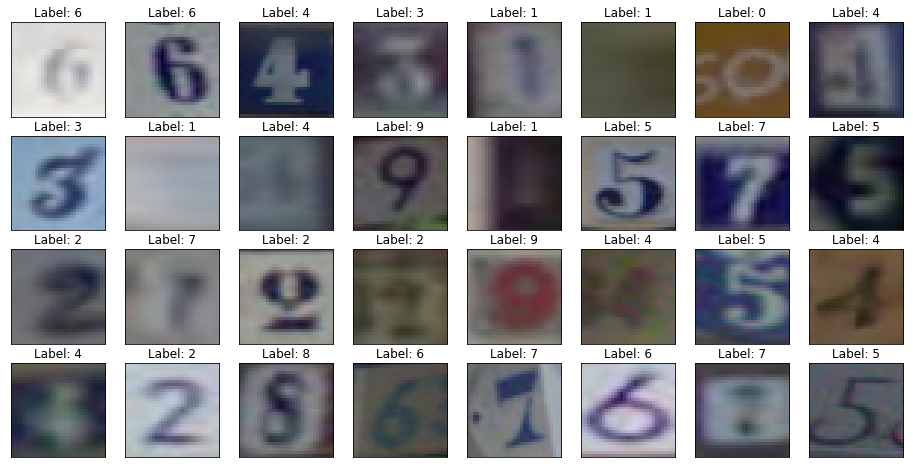

In [20]:
# Find some images containing 1 digit
single_digit = (y_train != 10).sum(1) == 1

# Display some exaples
plot_images(X_train[single_digit], 4, 8, y_train[single_digit]);

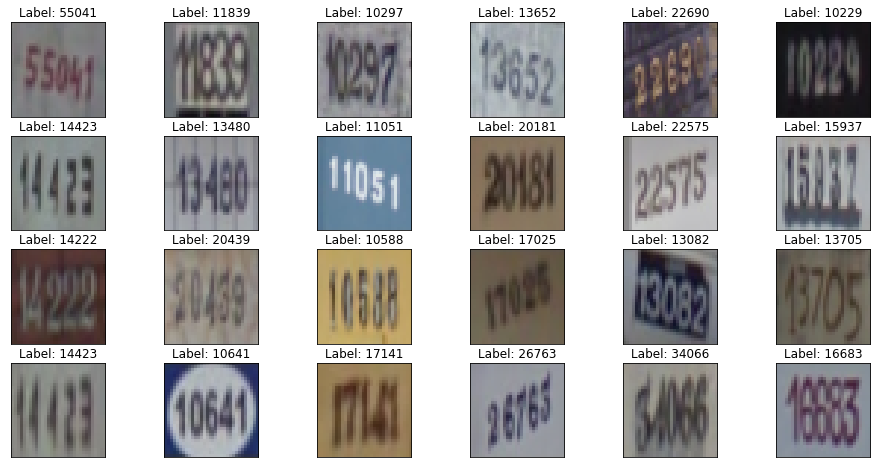

In [21]:
# Find some images with five digits
five_digits = (y_extra != 10).sum(1) == 5

# Display some examples 
plot_images(X_extra[five_digits], 4, 6, y_extra[five_digits]);

## Data Exploration

- Now that we have all this data, let's explore & visualze it to see what else we can learn from the data
- Plot the distributions of counts of each image (1 digit to 5 digits)
    - We notice that most images have 1-3 digits, and a smaller amount have 4-5 digits
    - Also, we notice that the extra set follows a slightly different distributions then the train and test set
- Plot the distributions of each individual digit 
    - Note that number 10 means there are no digits

In [22]:
# Train set
y_train_counts = np.unique((y_train != 10).sum(1), return_counts=True)

y_train_counts = list(zip(y_train_counts[0], y_train_counts[1]))
y_train_df_counts = pd.DataFrame(y_train_counts,  columns= ['Number of Digits', 'Count'])
y_train_df_counts.set_index('Number of Digits', inplace=True)

# Test set
y_test_counts = np.unique((y_test != 10).sum(1), return_counts=True)

y_test_counts = list(zip(y_test_counts[0], y_test_counts[1]))
y_test_df_counts = pd.DataFrame(y_test_counts, columns= ['Number of Digits', 'Count'])
y_test_df_counts.set_index('Number of Digits', inplace=True)

# Extra set
y_extra_counts = np.unique((y_extra != 10).sum(1), return_counts=True)

y_extra_counts = list(zip(y_extra_counts[0], y_extra_counts[1]))
y_extra_df_counts = pd.DataFrame(y_extra_counts, columns= ['Number of Digits', 'Count'])
y_extra_df_counts.set_index('Number of Digits', inplace=True)

combined_counts_df = pd.concat([y_train_df_counts, y_test_df_counts, y_extra_df_counts], 
                               keys=['Train', 'Test', 'Extra'],
                              names=['Dataset'])
combined_counts_df

Count
Dataset Number of Digits        
Train   1                   5137
        2                  18130
        3                   8691
        4                   1434
        5                      9
Test    1                   2483
        2                   8356
        3                   2081
        4                    146
        5                      2
Extra   1                   9385
        2                  71726
        3                 106789
        4                  14338
        5                    115

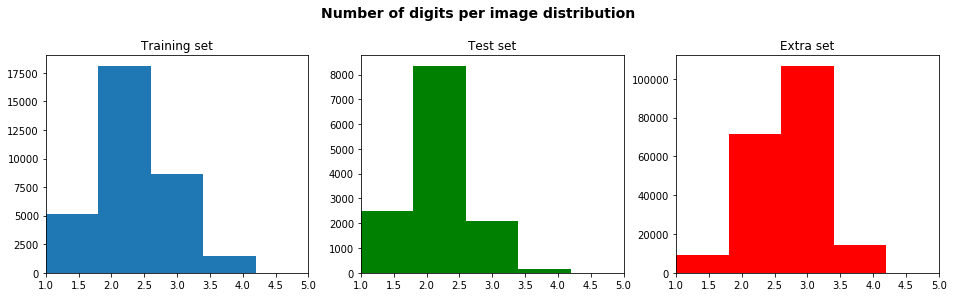

In [23]:
# Initialize the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

# Set the main figure title
fig.suptitle('Number of digits per image distribution', fontsize=14, fontweight='bold', y=1.05)

# Sequence length distribution - training set 
ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

# Sequence length distribution - test set 
ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

# Sequence length distribution - extra set 
ax3.hist((y_extra != 10).sum(1), bins=5, color='r')
ax3.set_title("Extra set");

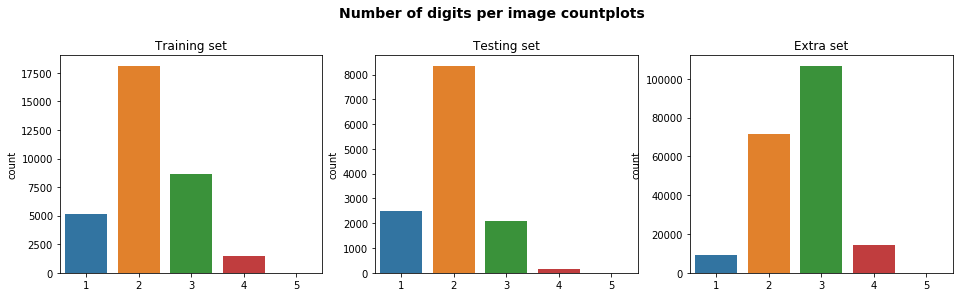

In [24]:
# Initialize the subplots
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

# Set the main figure title
fig.suptitle('Number of digits per image countplots', fontsize=14, fontweight='bold', y=1.05)


sns.countplot((y_train != 10).sum(1), ax=ax[0])
ax[0].set_title("Training set");

sns.countplot((y_test != 10).sum(1), ax=ax[1])
ax[1].set_title("Testing set");

sns.countplot((y_extra != 10).sum(1), ax=ax[2])
ax[2].set_title("Extra set");

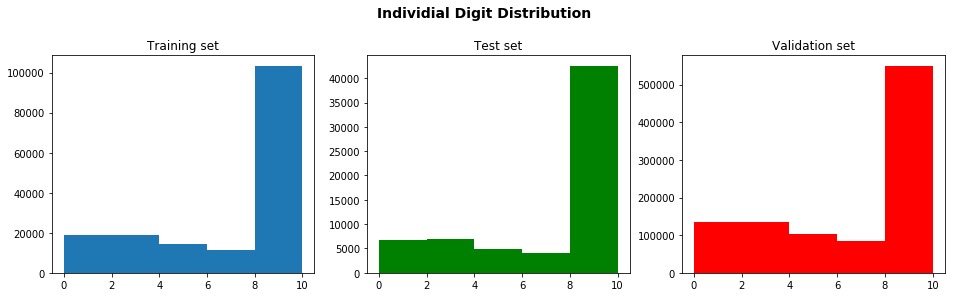

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Individial Digit Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train.flatten(), bins=5)
ax1.set_title("Training set");

ax2.hist(y_test.flatten(), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist(y_extra.flatten(), bins=5, color='r')
ax3.set_title("Validation set");

## Create Balanced Validation set

- From above, we notice that the classes are imbalanced. 
- Let's create a balanced validation set with an equal number 3of images with the same digit sequence lengths. 
- The extra set is a large set of easy samples and train set is a smaller set of more difficult samples. 
- Since we want our model to be robust, we will take more from the training set for validation
    - We will set aside about ~5% of the total images used for training for validation
        - We want a good enough sample size for validation that it will be statistically significant
    - This comes out to around ~10,000 images for validation
- Validation set:
    - 10,000 images with 4/5 taken from the training set and 1/5 from the extra set
        - 8,000 images from training set
        - 2,000 images from extra set
- We want to randomly sample the training & extra set to ensure the training set, validation set, and test set all have relatively the same distribution
    - This is important that each of these datasets are representative of the population

In [26]:
def random_sample(N, K):
    """Return a boolean mask of size N with K selections
    """
    mask = np.array([True]*K + [False]*(N-K))
    np.random.shuffle(mask)
    return mask

# Pick 8000 training and 2000 extra samples
sample1 = random_sample(X_train.shape[0], 8000)
sample2 = random_sample(X_extra.shape[0], 2000)

# Create valdidation from the sampled data
X_val = np.concatenate([X_train[sample1], X_extra[sample2]])
y_val = np.concatenate([y_train[sample1], y_extra[sample2]])

# Keep the data not contained by sample
X_train = np.concatenate([X_train[~sample1], X_extra[~sample2]])
y_train = np.concatenate([y_train[~sample1], y_extra[~sample2]])

# Moved to validation and training set
# del X_extra, y_extra 

print("Training", X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)

Training (225754, 32, 32, 3) (225754, 5)
Validation (10000, 32, 32, 3) (10000, 5)


### Dataset verification

- We want to verify the distributions are similiar across the datasets (train, val, test) in both number of digits per image & individual digit distribution
- For number of digits per image
    - We notice that generally that the three sets follow the same semi-normal distribution
    - Most of the number of digits per image are between 1 - 3 digits
- For individual digit distribution
    - We notice that all three datasets follow the same distribution

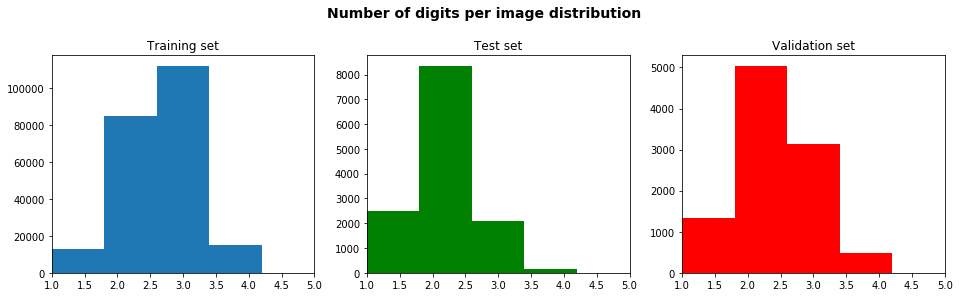

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Number of digits per image distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist((y_train != 10).sum(1), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(1, 5)

ax2.hist((y_test != 10).sum(1), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist((y_val != 10).sum(1), bins=5, color='r')
ax3.set_title("Validation set");

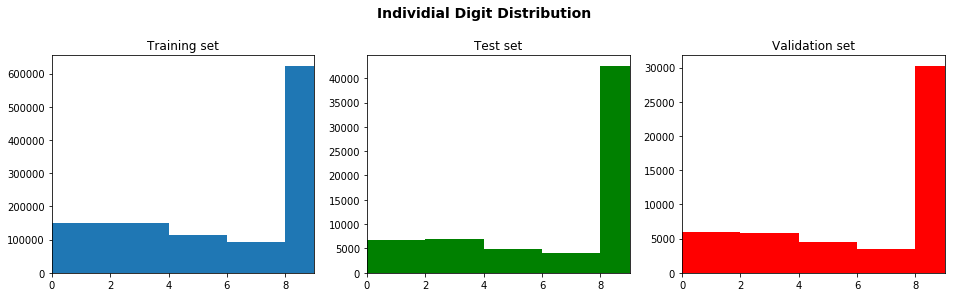

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(16, 4))

fig.suptitle('Individial Digit Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train.flatten(), bins=5)
ax1.set_title("Training set");
ax1.set_xlim(0, 9)

ax2.hist(y_test.flatten(), bins=5, color='g')
ax2.set_title("Test set");

ax3.hist(y_val.flatten(), bins=5, color='r')
ax3.set_title("Validation set");

## Storing data to disk

- Just incase, we will save a copy of the unnormalized & RGB images

In [29]:
# Create file
h5f = h5py.File('data/SVHN_multi_digit_rgb.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=X_val)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

## Image preprocessing

- Convert RGB images to grayscale images
- Normalization of images by subtracting by mean & dividing by standard deviation to get the z-scores

In [30]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

# Transform the images to greyscale
X_train = rgb2gray(X_train).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)
X_val = rgb2gray(X_val).astype(np.float32)

### Normalization

- Z-score normalization (i.e. standardization) to make values in between [0, 1] with mean 0 and standard deviation 1
    - Convert distributions into the standard normal distribution using the Z-score
- We want to do this because we want all the features to be in a similiar range, since when we train out neural network, we will be multiplying weights and adding biases 
    - We want to ensure that gradients don't go out of control

In [31]:
# Calculate the mean on the training data
train_mean = np.mean(X_train, axis=0)

# Calculate the std on the training data
train_std = np.std(X_train, axis=0)

# Subtract it equally from all splits
train_norm = (X_train - train_mean) / train_std
test_norm = (X_test - train_mean)  / train_std
val_norm = (X_val - train_mean) / train_std

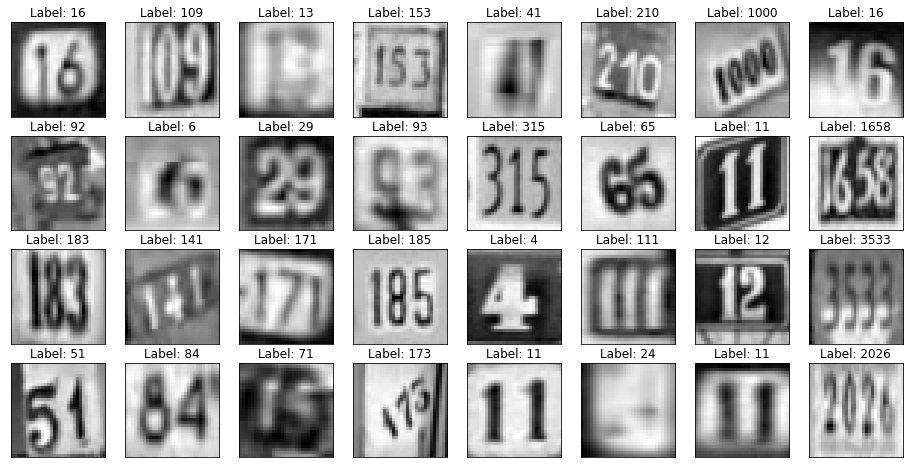

In [32]:
# Let's make sure that the normalization did not mess up the images

plot_images(train_norm, 4, 8, y_train)

In [33]:
# Create file
h5f = h5py.File('data/SVHN_multi_digit_norm_grayscale.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=train_norm)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=test_norm)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=val_norm)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

## Conclusion

- Finished preprocessing step of images
- Next, we will design & implement the neural network to train the model & do predictions on the test set
    - `svhn-model.ipynb` will be the jupyter notebook to run next